In [5]:
import torch
import pickle
import pandas as pd
import numpy as np
import os
import re 
import random
import glob
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.io import read_image
import pytorch_lightning as pl
import numpy as np

from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data as tdata
from pathlib import Path

from PIL import Image
import collections

from torch.utils.data import Dataset
from torchvision import transforms as T
from sklearn.model_selection import GroupShuffleSplit
import pandas as pd
from statistics import mode

In [36]:
#load the table

data = pd.read_csv("../imagine/image_quality.csv")

train_path = "../imagine/train.pickle"
test_path = '../imagine/test.pickle'
with open(train_path, 'rb') as f:
        x = pickle.load(f)

train_file = x.loc[x.class_label.isin(["psoriasis"]), :]
train_file.reset_index(inplace=True)
train_file = train_file.loc[:, ~train_file.columns.str.contains('^index')]


with open(test_path, 'rb') as f:
    x = pickle.load(f)

test_file = x.loc[x.class_label.isin(["psoriasis"]), :]
test_file.reset_index(inplace=True)
test_file = test_file.loc[:, ~test_file.columns.str.contains('^index')]
train_images = train_file.image_id.tolist()
train_images2 = [i[:-4] for i in train_images]
#print(test_images2)
train_meta_data = data.loc[data.platformImageId.isin(train_images2)]

test_images = test_file.image_id.tolist()
test_images2 = [i[:-4] for i in test_images]
#print(test_images2)
test_meta_data = data.loc[data.platformImageId.isin(test_images2)]
len(train_meta_data), len(test_meta_data)

38224

# Checking that All the rows exist in the dataset

In [ ]:
data_dir = "imagine/images"
#create a list of the unique image ids that will iterately check their existance in the file
imgId_list = data['platformImageId'].unique().tolist()
print(len(imgId_list))
#a list of images that dont exist
nonExisting = []

for Id in imgId_list:
    path = data_dir+"/"+Id+".png"
    if Path(path).is_file():
        pass
    else:
        nonExisting.append(Id)
print(len(nonExisting))
print(len(data.loc[(data["platformImageId"].isin(nonExisting))]))
data = data.loc[(~data["platformImageId"].isin(nonExisting))] 
print(len(data))


In [ ]:
data_dir = "imagine/images"
blurry = data_dir+"/"+data.loc[data.blurry == True, "platformImageId"]+".png"
image = Image.open(blurry.iloc[0])
image = T.ToTensor()(image)
plt.imshow(np.transpose(image, (1, 2, 0)))
plt.show()
far = data_dir+"/"+data.loc[data.too_far_away == True, "platformImageId"]+".png"
image = Image.open(far.iloc[1])
image = T.ToTensor()(image)
plt.imshow(np.transpose(image, (1, 2, 0)))
plt.show()
light = data_dir+"/"+data.loc[data.bad_light == True, "platformImageId"]+".png"
image = Image.open(light.iloc[3])
image = T.ToTensor()(image)
plt.imshow(np.transpose(image, (1, 2, 0)))
plt.show()
covered = data_dir+"/"+data.loc[data.lesion_covered == True, "platformImageId"]+".png"
image = Image.open(covered.iloc[2])
image = T.ToTensor()(image)
plt.imshow(np.transpose(image, (1, 2, 0)))
plt.show()
resolution = data_dir+"/"+data.loc[data.low_resolution == True, "platformImageId"]+".png"
image = Image.open(resolution.iloc[0])
image = T.ToTensor()(image)
plt.imshow(np.transpose(image, (1, 2, 0)))
plt.show()
framing = data_dir+"/"+data.loc[data.bad_framing == True, "platformImageId"]+".png"
image = Image.open(framing.iloc[2])
image = T.ToTensor()(image)
plt.imshow(np.transpose(image, (1, 2, 0)))
plt.show()
SNV = data_dir+"/"+data.loc[data.diagnosis == "SNV", "platformImageId"]+".png"
image = Image.open(SNV.iloc[2])
image = T.ToTensor()(image)
plt.imshow(np.transpose(image, (1, 2, 0)))
plt.show()
lesion = data_dir+"/"+data.loc[data.diagnosis == "L98.2", "platformImageId"]+".png"
image = Image.open(lesion.iloc[0])
image = T.ToTensor()(image)
plt.imshow(np.transpose(image, (1, 2, 0)))
plt.show()
CNS = data_dir+"/"+data.loc[data.diagnosis == "CNS", "platformImageId"]+".png"
image = Image.open(CNS.iloc[2])
image = T.ToTensor()(image)
plt.imshow(np.transpose(image, (1, 2, 0)))

plt.show()

In [ ]:
#print(data)
#find any row that has Nan values
data2 = data[data['diagnosis'].isna()]
print(len(data[data['diagnosis'].isna()]), len(data[data['platformImageId'].isna()]), len(data[data['dermId'].isna()]), len(data[data['patientId'].isna()]))


## delete CNV data as they are for this task trivial

In [89]:
#SNV= skin not visible, CNS: clear skin, NEP = quality issues
#delete the CNV data
data = data[data['diagnosis'] != 'SNV']
print(len(data.dermId.unique())) #12 dermatologists in total
print(len(data))

12
202534


# Ensuring no duplicates

In [138]:
data = pd.read_csv("~/imaginePilot-v1.0/imagine/updated_image_quality.csv")
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
#data.head()
print(len(data))
#delete the duplicate images
data.drop_duplicates('platformImageId', inplace=True)
data.reset_index(inplace=True) 
print(len(data))
data = data.loc[:, ~data.columns.str.contains('^index')]
data

print(data)

                             externalImageId  \
0       93ef4f3d-5cb6-4a20-abf7-d08be30a0d1b   
1       e95dee09-70e0-4cc7-b3a9-a8b4677dfc77   
2       d8aa4a9f-2c26-47a9-92a9-0fc01b569848   
3       1ec0b303-43a5-41b7-a8f4-9f2fb9224dd4   
4       441682a2-413f-431e-91b5-76df3dbb9d9f   
...                                      ...   
202529  8eb6bde6-a37f-4c23-81f5-fa224829abf3   
202530  124e46f2-29ab-4e1a-9b83-4db678751fc9   
202531  3aa16e10-2cf4-481d-be23-d44416e4bcbb   
202532  21cde7d3-cd32-4ea8-bc79-42ff39be59c4   
202533  ed255334-cc69-484a-ad4b-351b6054b4ad   

                             platformImageId  \
0       e72059a5-aa6b-4e55-aaea-cf563662d73a   
1       2faf7232-d231-4580-9adb-cdb21f9cfd78   
2       77f2f617-4b9d-4bd0-9cce-dcc27906127e   
3       2d90e678-53da-4f24-8fe5-c97d850cf045   
4       b9e237d7-b632-4d27-a05a-0d39245bd3af   
...                                      ...   
202529  a5861aaf-ed2e-4f3a-894c-13c34931322c   
202530  0c719f10-0af2-4674-b7a7-800f5e6

# Data Analysis

7838
(38343, 12)
bad framing: 784 bad_light: 3133 blurry: 4245 lesion covered: 230 low resolution: 1805 too far away: 543


/home/ubuntu/venvs/demo_env/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


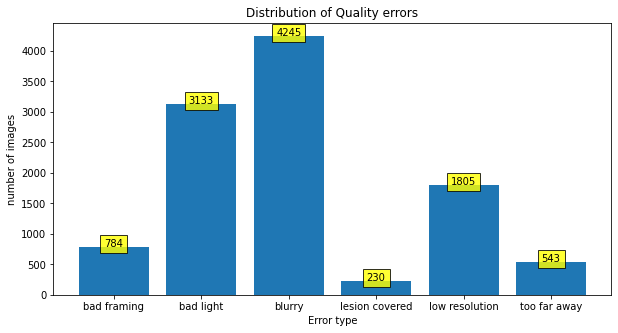

"\nage = data['patientId'].value_counts(dropna=False)\nage2 = age.to_frame()\nage3 = age2.transpose()\n#limit it to a reasonable domain\n#x = np.array(age.index.tolist())\n#y = np.array([age[i] for i in range(len(age))])\n#plt.bar(x,y)\nage3.hist()\nplt.show()\n\ntype(age2)\nage3"

In [147]:
NEP_count = np.size(np.where(data["diagnosis"]== "NEP"))
data_count = data.shape
print(NEP_count)
print(data_count)
bad_framing_count = np.size(np.where(~data['bad_framing'].isnull()))
bad_light_count = np.size(np.where(~data['bad_light'].isnull()))
blurry_count = np.size(np.where(~data['blurry'].isnull()))
lesion_covered_count = np.size(np.where(~data['lesion_covered'].isnull()))
low_resolution_count = np.size(np.where(~data['low_resolution'].isnull()))
too_far_away_count = np.size(np.where(~data['too_far_away'].isnull()))

print("bad framing:", bad_framing_count, "bad_light:", bad_light_count, "blurry:", blurry_count, "lesion covered:", lesion_covered_count, "low resolution:", low_resolution_count, "too far away:", too_far_away_count)
x = np.array(["bad framing","bad light","blurry","lesion covered","low resolution","too far away"])
y = np.array([bad_framing_count, bad_light_count, blurry_count, lesion_covered_count, low_resolution_count, too_far_away_count])
plt.figure(figsize = (10, 5))
plt.bar(x,y)
for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center',
                 Bbox = dict(facecolor = 'yellow', alpha =.8))
plt.title("Distribution of Quality errors")
plt.xlabel("Error type")
plt.ylabel("number of images")
plt.savefig("errorTypeNumbers.png")     
plt.show()


# Patient count

In [148]:
#how many patients in total
patient_count = len(train_file.patientId.unique())+len(test_file.patientId.unique())


18679


In [79]:
# todo: check how many patients are diagnosed different types of lesions
print("number of patients that are only diagnosed NEP: ", len(patient.loc[~patient["NEP"].isna() & patient["CNS"].isna() & patient["lesion"].isna()]))
print("number of patients that are only diagnosed CNS or lesion: ", len(patient.loc[patient["NEP"].isna()]))

number of patients that are only diagnosed NEP:  7264
number of patients that are only diagnosed CNS or lesion:  8791


# Split the data into common, NEP and CNS|lesion on patient level

In [80]:
#CNS |& lesion: train section 1
# Note: a patient can have images of both cns and lesion, but each image is either lesion OR CNS
lesion_cns_patients = patient.loc[patient["NEP"].isna(),["patientId", "NEP","CNS","lesion"]] 
lesion_cns_index = data.patientId.isin(lesion_cns_patients.patientId.tolist()).values.tolist()
lesion_cns_images = data.iloc[lesion_cns_index]
print("lesion or CNS patients details: ", "#patients: ",len(lesion_cns_patients),"#images with CNS: ",lesion_cns_patients.CNS.sum(), "#images with lesion: ",lesion_cns_patients.lesion.sum(), "#images: ",len(lesion_cns_images))

#NEP only: test 1
NEP_patients = patient.loc[~patient["NEP"].isna() & patient["CNS"].isna() & patient["lesion"].isna(),["patientId", "NEP", "CNS","lesion"]]
NEP_index = data.patientId.isin(NEP_patients.patientId.tolist()).values.tolist()
NEP_images = data.iloc[NEP_index]
print("Only NEP patients details: ", "#patiens: ",len(NEP_patients),"#NEP images: ", NEP_patients.NEP.sum(), "NEP images: ", len(NEP_images))

#common
lesion_cns_nep_patients = patient.loc[~patient["NEP"].isna() & ~patient["CNS"].isna() & ~patient["lesion"].isna(),["patientId", "NEP","CNS","lesion"]]
lesion_cns_nep_index = data.patientId.isin(lesion_cns_nep_patients.patientId.tolist()).values.tolist()
lesion_cns_nep_images = data.iloc[lesion_cns_nep_index]
print("patients with a mix of all the labels: ", "#patients", len(lesion_cns_nep_patients), "# CNS images: ", lesion_cns_nep_patients.CNS.sum(), "# NEP images: ", lesion_cns_nep_patients.NEP.sum(),"# lesion images: ", lesion_cns_nep_patients.lesion.sum(), "#images", len(lesion_cns_nep_images))

lesion_nep_patients = patient.loc[~patient["NEP"].isna() & patient["CNS"].isna() & ~patient["lesion"].isna(),["patientId", "NEP","CNS","lesion"]]
lesion_nep_index = data.patientId.isin(lesion_nep_patients.patientId.tolist()).values.tolist()
lesion_nep_images = data.iloc[lesion_nep_index]
print("patients with a mix of lesion nep labels: ", "#patients: ",len(lesion_nep_patients),"# lesion images: ", lesion_nep_patients.lesion.sum(), "#NEP images: ", lesion_nep_patients.NEP.sum(), "# lesion nep images", len(lesion_nep_images))

cns_nep_patients = patient.loc[~patient["NEP"].isna() & ~patient["CNS"].isna() & patient["lesion"].isna(),["patientId", "NEP","CNS","lesion"]]
cns_nep_index = data.patientId.isin(cns_nep_patients.patientId.tolist()).values.tolist()
cns_nep_images = data.iloc[cns_nep_index]
print("patients with a mix of cns nep labels: ", "#patients: ", len(cns_nep_patients),"#cns images: ", cns_nep_patients.CNS.sum(), "#nep images: ", cns_nep_patients.NEP.sum(), "#images: ", len(cns_nep_images))


lesion or CNS patients details:  #patients:  8791 #images with CNS:  3247.0 #images with lesion:  11502.0 #images:  14749
Only NEP patients details:  #patiens:  7264 #NEP images:  9090.0 NEP images:  9090
patients with a mix of all the labels:  #patients 246 # CNS images:  388.0 # NEP images:  631.0 # lesion images:  964.0 #images 1983
patients with a mix of lesion nep labels:  #patients:  1793 # lesion images:  7099.0 #NEP images:  3643.0 # lesion nep images 10742
patients with a mix of cns nep labels:  #patients:  585 #cns images:  791.0 #nep images:  988.0 #images:  1779


In [82]:
common_labels = lesion_cns_nep_images.append(lesion_nep_images, ignore_index=True)
common_labels = common_labels.append(cns_nep_images, ignore_index=True)
print(len(common_labels.platformImageId.unique()),len(lesion_cns_nep_images)+len(lesion_nep_images)+len(cns_nep_images), len(cns_nep_patients)+len(lesion_nep_patients)+len(lesion_cns_nep_patients), len(common_labels.patientId.unique()))
common_labels 

14504 14504 2624 2624


,externalImageId,platformImageId,patientId,bad_framing,bad_light,blurry,lesion_covered,low_resolution,too_far_away,majority
0,8c8c14af-defd-4a46-ac23-5d7bfc83de87,d02d681a-f5a3-4db5-a9d0-f4b122000f83,f84d5a06-2ce9-4c58-bbe4-6e7a42b58aaa,NaN,NaN,NaN,NaN,NaN,NaN,NEP
1,03c57dad-b96e-4723-a614-c99a3cd45690,a639da15-fb86-46b9-91af-2b6d22140cc6,f07cd086-f89c-455b-b74c-821c9bf13bd3,NaN,True,NaN,NaN,NaN,NaN,NEP
2,f675a9b4-9edb-4a8b-abbb-a14b666172a5,27ea173d-8514-42a2-8c92-d4c93f0d76bf,8a393fd6-b34b-4fbc-8b45-e54f5547eb5c,NaN,NaN,NaN,NaN,NaN,NaN,other
3,5cae2eb8-353e-482f-bd2e-7cb86c0be02c,7827a009-f15f-4508-9cf1-6ccbb074e55b,96a613d6-932d-4705-acf0-70d4149a82fe,True,True,True,NaN,NaN,NaN,NEP
4,e870f3c4-5a27-4356-a11c-dd821326c85a,5de44c73-d425-4d76-ac5f-df7063fe0907,ea4ab023-83f5-4aab-8a0a-052500855dbc,NaN,NaN,NaN,NaN,NaN,NaN,other
...,...,...,...,...,...,...,...,...,...,...
14499,c6410bd4-490a-4490-bc5c-57beaf86abeb,2c26ab18-0d14-4c25-a779-24ee752b856f,11a484e9-4b83-45d0-9604-6d4533314ca3,True,NaN,NaN,NaN,NaN,NaN,NEP
14500,eed12421-4811-470f-aa7f-6ee10ad15bb9,65ce7f5c-c572-404b-9365-9dff3ea8dfbb,00328db9-139c-4a57-a069-b3c43c6943c6,NaN,True,NaN,NaN,NaN,NaN,NEP
14501,586e80e8-60d6-4b5f-9ff2-054d7ab495e7,9d5ee9d9-e05e-4892-93c2-4a41057b273a,f8ebd3b0-5f05-48e7-8f45-6c4b18e8776e,NaN,True,NaN,NaN,NaN,NaN,NEP
14502,2a40c988-bf18-4b28-997e-74003ab9a895,ae4d71fc-c22f-4d7f-a8d4-4a5bc151ab9c,ea4718e8-1cf6-479a-9a73-5e5e8ae60675,True,NaN,NaN,NaN,NaN,NaN,NEP


/home/ubuntu/venvs/demo_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  if __name__ == '__main__':


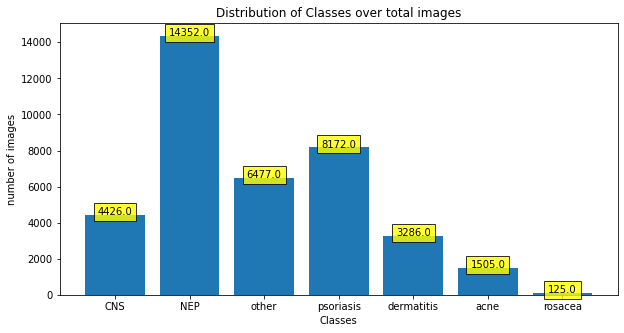

In [32]:
patient = data.patientId.unique()
counts = np.sum(patient, 0)
#plot classes
x = np.array(["CNS","NEP","other","psoriasis", "dermatitis", "acne","rosacea"])
y = np.array([counts.CNS, counts.NEP, counts.other, counts.psoriasis, counts.dermatitis, counts.acne, counts.rosacea])
plt.figure(figsize = (10, 5))
plt.bar(x,y)
for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center',
                 Bbox = dict(facecolor = 'yellow', alpha =.8))
plt.title("Distribution of Classes over total images")
plt.xlabel("Classes")
plt.ylabel("number of images")
plt.savefig("classdistribution.png")     
plt.show()

### check for superusers

In [26]:
patient["count"] = np.sum(patient, 1)
#print(patient)
df = patient[patient["count"] > 15]
print(len(df))
#print(test)
superpatientsId = df.patientId #202 patients in total, 170 of these patients are in training. 
print(len(superpatientsId))
indices_superuserimages = np.where(test.patientId.isin(superpatientsId)) #4888 images for these patients on train dataset
superuser_images = test.iloc[indices_superuserimages]
print(len(superuser_images))

superuser_images = superuser_images.sort_values('patientId',ascending = False).groupby('patientId').head(15) #for each value of patientId I chose the first 15 images
print(superuser_images)


test= test.drop(test[(test.platformImageId.isin(superuser_images.platformImageId.tolist()).values.tolist()) & (test.patientId.isin(superpatientsId))].index)
print("test",test)

test.reset_index(inplace=True) 
test = test.loc[:, ~test.columns.str.contains('index')]




202
202
1163
                           externalImageId  \
2420  ae65f389-2c91-4d31-9e6c-1542654cf065   
980   72a8bb0d-c8ae-4e60-a8da-e79faf0f6e22   
934   23856fd1-e2ee-4957-8a27-1fd5f1659f20   
2102  cb97cfbd-7202-40b0-8e9e-47550894f695   
2090  9979785f-8266-4719-bebc-c480bfcef0b3   
...                                    ...   
2309  4d2a6e5a-df76-46ec-9d46-c6b37df8db50   
2325  9098219c-f681-4cce-8856-1e581ca73945   
1628  4ecefd57-4444-4ff8-927c-b5d12c381b72   
2576  31878428-19aa-4ae7-9a7c-fa22dd80f200   
1451  f560ef39-6a43-4edd-84b8-a2883bad414f   

                           platformImageId  \
2420  eefbe37e-364d-4d56-bb92-6af1e8f538fe   
980   31e31813-6b6a-4e14-aa3e-2df060f1b085   
934   790b3625-f084-4c7c-9ee9-631ccac5db6a   
2102  9035faeb-0de1-406e-9959-56e707ce0013   
2090  5320775b-dcc5-4a91-8bb1-f903373caed5   
...                                    ...   
2309  eac1b531-4072-48b3-8584-547eae495da7   
2325  3f6e3743-f554-4c9a-8f8e-bb134b7bd61f   
1628  72a1140c-8e33-